# **Import Lib**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Loading MNIST dataset**

In [2]:
# make directorch to save dataset
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
        
createFolder('./data')

In [3]:
# define transformation
ds_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
])

In [4]:
# load MNIST dataset
train_ds = datasets.MNIST('/content/data',train=True, download=True, transform=ds_transform)
val_ds = datasets.MNIST('/content/data',train=False, download=True, transform=ds_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [5]:
print(len(train_ds), len(val_ds))

60000 10000


In [6]:
# define data loader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 128, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


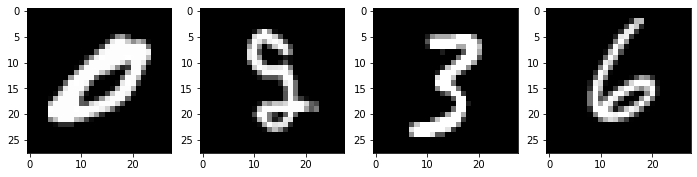

In [7]:
# check sample image
for x, y in train_dl:
    print(x.shape, y.shape)
    break

num = 4
img = x[:num]

plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    plt.imshow(to_pil_image(0.1307*img[i]+0.3081), cmap='gray')

# **Define Teacher model**

In [8]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)
    
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x,p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x,p=0.8)
        x = self.fc3(x)
        return x

In [9]:
# check
x = torch.randn(16,1,28,28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output.shape)

torch.Size([16, 10])


In [10]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

teacher.apply(initialize_weights)

Teacher(
  (fc1): Linear(in_features=784, out_features=1200, bias=True)
  (bn1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1200, out_features=1200, bias=True)
  (bn2): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1200, out_features=10, bias=True)
)

# **Train teacher model**

In [11]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

### ReduceLROnPlateau

> https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html



In [12]:
# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [13]:
# set hyper parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [14]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr= 0.001
Copied best model weights!
train loss: 0.007295, val loss: 0.002339, accuracy: 91.06, time: 0.8305 min
----------
Epoch 1/29, current lr= 0.001
Copied best model weights!
train loss: 0.004856, val loss: 0.002047, accuracy: 92.33, time: 1.6392 min
----------
Epoch 2/29, current lr= 0.001
Copied best model weights!
train loss: 0.004143, val loss: 0.001719, accuracy: 93.28, time: 2.4331 min
----------
Epoch 3/29, current lr= 0.001
Copied best model weights!
train loss: 0.003701, val loss: 0.001564, accuracy: 94.27, time: 3.2131 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.003471, val loss: 0.001570, accuracy: 94.02, time: 4.0064 min
----------
Epoch 5/29, current lr= 0.001
Copied best model weights!
train loss: 0.003316, val loss: 0.001535, accuracy: 94.31, time: 4.7925 min
----------
Epoch 6/29, current lr= 0.001
Copied best model weights!
train loss: 0.003121, val loss: 0.001447, accuracy: 94.36, time: 5.5752 min
----------
Epoch 7/29, current

### Visualization_Teacher_model

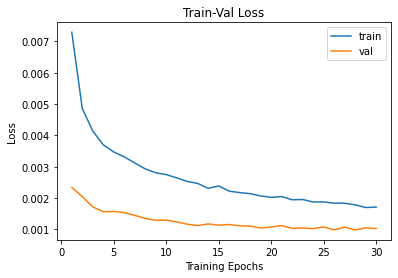

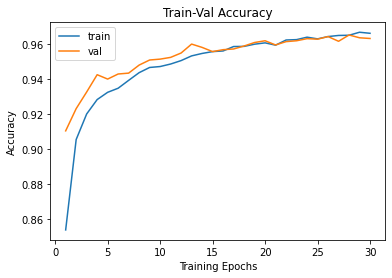

In [15]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# **Define Student model**

teacher의 지식을 transfer할 student model을 정의합니다.

In [16]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
# check
x = torch.randn(16,1,28,28).to(device)
student = Student().to(device)
output = student(x)
print(output.shape)

torch.Size([16, 10])


In [18]:
# weight initialization
student.apply(initialize_weights)

Student(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=800, bias=True)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=800, out_features=10, bias=True)
)

# **Knowledge Distillation**

In [19]:
teacher = Teacher().to(device)
# load weight
teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

student = Student().to(device)

# optimizer
opt = optim.Adam(student.parameters())

soft label\
\
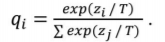

knowledge distillation loss\
\
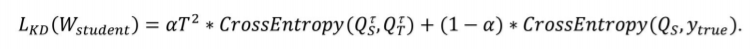

In [20]:
# knowledge distillation loss
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha)
    + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

KLDivLoss


> https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html



In [21]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

# **Train student model**

In [22]:
num_epochs= 30

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/29, current lr= 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


train loss: 0.032822, val loss: 0.001012, accuracy: 96.65, time: 0.6308 min
----------
Epoch 1/29, current lr= 0.001
train loss: 0.028616, val loss: 0.000808, accuracy: 97.22, time: 1.2552 min
----------
Epoch 2/29, current lr= 0.001
train loss: 0.028087, val loss: 0.000804, accuracy: 97.32, time: 1.8793 min
----------
Epoch 3/29, current lr= 0.001
train loss: 0.027836, val loss: 0.000726, accuracy: 97.56, time: 2.5027 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.027677, val loss: 0.000777, accuracy: 97.53, time: 3.1254 min
----------
Epoch 5/29, current lr= 0.001
train loss: 0.027499, val loss: 0.000662, accuracy: 97.74, time: 3.7418 min
----------
Epoch 6/29, current lr= 0.001
train loss: 0.027352, val loss: 0.000687, accuracy: 97.69, time: 4.3573 min
----------
Epoch 7/29, current lr= 0.001
train loss: 0.027362, val loss: 0.000659, accuracy: 97.76, time: 4.9747 min
----------
Epoch 8/29, current lr= 0.001
train loss: 0.027083, val loss: 0.000690, accuracy: 97.69, time:

### Visualization_student_model

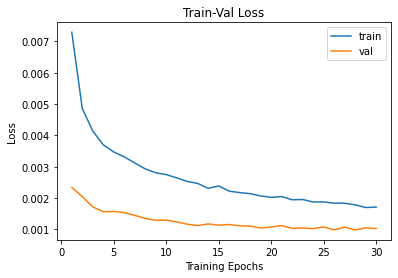

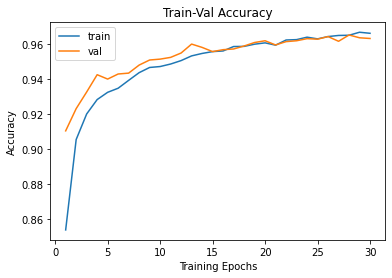

In [23]:
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()